# What is the Optimal Angle from the Ground that a Shooter Should Fire A Bullet at a Falling Clay Pigeon While Playing Pigeon Ball?

Julia Benton and Talia Tandler

December 2018

# Question
For our project, we researched the forces that act on a fired projectile and a free-falling object to answer the design question: What is the optimal angle from the ground that a shooter should fire a bullet at a falling clay pigeon while playing the new game of pigeon ball? Inspired by both clay pigeon shooting and skeet shooting, pigeon ball is Talia and Julia's creation that involves a shooter firing a shotgun across the length of a football field at a clay pigeon being dropped straight down from the top of a football goal post. 

In our model, we wanted to know what the optimal angle someone playing pigeon ball should shoot a shotgun at so that the bullet and clay pigeon would reach the same (x,y) position and the clay pigeon would break. We gave the bullet fired from the gun a given initial velocity vector. The pigeon was dropped with an initial velocity of 0 m/s in the y-direction that increased during the drop, and a velocity of 0 m/s in the x-direction that stayed constant throughout the fall. We implemented net force physics equations for this translational motion model, considering the drag force and gravitational force acting on both the bullet and pigeon. We modelled the parabolic motion of the projectile bullet and the free fall of the pigeon. We decided to not include terminal velocity of either object in our model. We used Cartesian coordinates and defined our origin of (0,0) to be the point on the field where the shooter's feet are. The clay pigeon drops at the same instant the gun fires. 

Our model and question are important because they can help skeet shooter and hunters aim accurately at a free-falling pigeon or target object. 

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

# Model

In [2]:
#define the units used in the code

m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

### Set up parameters

We first defined all of the constants and initial conditions that we would need in later functions. This included initial velocities and angles, as well as the mass of the pigeon and bullet. Our numbers for these parameters came from reliable sources listed at the end of the model. We had diameters for the clay pigeon and bullet in params because we modelled these objects as spheres to simplify our model. The height of the pigeon and horizontal distance between the pigeon and bullet are taken from football field measurements. The drag coefficient for a free-falling sphere was used since the objects were modelled as spheres.

In [3]:
params = Params(h_bullet = 1.524 *m, #starting height of the bullet being shot
                h_pigeon = 12.192 *m, #height of the pigeon before drop 
                mass_bullet = 0.002 * kg, #mass of bullet
                mass_pigeon = 0.105 * kg, #mass of clay pigeon
                diameter_pigeon = 0.11 * m, #diameter of spherical pigeon 
                diameter_bullet = 0.0027 * m,  #diameter of spherical bullet 
                g = 9.8 * m/s**2, #acceleration of gravity
                rho = 1.225 * kg/m**3, #density of air
                t_0 = 0 * s, #starting time of the system
                t_end = 30 * s, #end time of the system
                angle_b = 0 *degree, #angle from the ground bullet is shot
                angle_p = 0*degree, #starting angle of the pigeon
                v_bullet_0 = 100 * m/s, #initial velocity vector of the bullet
                v_pigeon_0 = 0 *m/s, #initial velocity of the pigeon-dropped not thrown
                dist_0 = 109.728 *m, #horizontal distance b/w bullet & pigeon- bullet @ origin (0,0)
                C_d = 0.187) #drag coefficient for free-falling sphere

,values
h_bullet,1.524 meter
h_pigeon,12.192 meter
mass_bullet,0.002 kilogram
mass_pigeon,0.105 kilogram
diameter_pigeon,0.11 meter
diameter_bullet,0.0027 meter
g,9.8 meter / second ** 2
rho,1.225 kilogram / meter ** 3
t_0,0 second
t_end,30 second


### Make System

After defining our parameters, we made a system to break down the x and y components of the bullet's and the clay pigeon's starting velocity. We also defined an initial state function to store the initial conditions of position and velocity that would not change and would keep the conditions that model began with.

In [4]:
def make_system(params):
    
    unpack (params)
    
    area_pigeon = np.pi * (diameter_pigeon/2)**2
    area_bullet = np.pi * (diameter_bullet/2)**2
    
    #convert angle to radians from radians
    theta_b = np.deg2rad(angle_b)
    theta_p = np.deg2rad(angle_p)
    
    #compute x and y components of velocity from angle and velocity in params
    vxb, vyb = pol2cart(theta_b, v_bullet_0)
    vxp, vyp = pol2cart(theta_p, v_pigeon_0)
    
    #make initial state w/ inital height and velocity
    init = State(xp=dist_0, xb=0, yp=h_pigeon, yb=h_bullet, vxp=vxp, vxb=vxb, vyp=vyp, vyb=vyb)
    
    return System(params,init=init, area_pigeon = area_pigeon, area_bullet = area_bullet)

### Calculating Drag Force

Before running through the simulation, we calculated the drag forces acting on each of the objects in the system using values from params. The bullet experienced drag force in the negative y-direction and negative x-direction. The pigeon experienced drag force in the positive y-direction. This force was computed as and returned by the function as a vector.

In [5]:
def drag_force_bullet(Vb, system):
    
    unpack (system)
    
    #calc mag & direction of bullet drag force vector 
    mag_bullet = -rho*Vb.mag**2 * C_d * area_bullet/2 
    direction_bullet = Vb.hat()                       
    f_drag_bullet = direction_bullet * mag_bullet   
    
    return f_drag_bullet

In [6]:
def drag_force_pigeon(Vp, system):
    
    unpack (system)
    
    #calc mag & direction of pigeon drag force vector 
    mag_pigeon = -rho*Vp.mag**2 * C_d * area_pigeon/2 
    direction_pigeon = Vp.hat()                      
    f_drag_pigeon = direction_pigeon * mag_pigeon      
    
    return f_drag_pigeon

### Slope function

We defined a slope function to compute the derivatives of the state variables. Since the state variables were position and velocity, we created a velocity vector of the bullet and pigeon using the components from the state. We also took the derivative of velocity to find the acceleration of the objects. The objects had both drag and gravitational forces acting on them, so the accelerations were added together for each to get net acceleration. Because drag force and gravity were in opposing directions to the acceleration due to applied force on the shot bullet, we were able to get the total accelerations of this object and map the trajectories of the objects.

In [7]:
def slope_func (state,t,system): #computes derivatives of the state variables
    
    xp, xb, yp, yb, vxp, vxb, vyp, vyb = state
    unpack (system)
    
    #make velocity vectors of the pigeon and the bullet
    Vp = Vector(vxp,vyp) 
    Vb = Vector(vxb,vyb)
    
    #calculate acceleration of drag and gravity on the bullet and the pigeon
    a_drag_bullet = drag_force_bullet(Vb, system) / mass_bullet
    a_drag_pigeon = drag_force_pigeon (Vp , system) / mass_pigeon
    a_grav = Vector(0,-g)
    
    #combine drag and gravity to get the total acceleration on the bullet and pigeon
    a_bullet = a_drag_bullet + a_grav
    a_pigeon = a_drag_pigeon + a_grav
    
    return vxp, vxb, vyp, vyb, a_pigeon.x, a_bullet.x, a_pigeon.y, a_bullet.y 

### Event Function

We next made an event function that stops the simulation when the bullet and the pigeon have the same x-position. We used the knowledge that the x-position of the bullet and pigeon were the same later to our advantage when running the ode solver and finding what the difference in the pigeon and bullet's y-position were. 

In [8]:
def event_func(state,t,system):
    """Stop when the x coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: zero
    """
    xp, xb, yp, yb, vxp, vxb, vyp, vyb = state
    return xp - xb  #this will stop the simulation when x position of pigeon and bullet are same 

We tested our code below here to make sure the event function was working correct. This value of 109.728 meters is what we expected  because the pigeon is falling straight down in a vertical line and its' x-position is unchanging. Therefore, the objects collide at the pigeon's x-position.

In [9]:
system=make_system(params)
event_func(system.init,0,system)

<Quantity(109.728, 'meter')>

In [10]:
print(slope_func(system.init,0,system)) #testing code

(<Quantity(0.0, 'meter / second')>, <Quantity(100.0, 'meter / second')>, <Quantity(0.0, 'meter / second')>, <Quantity(0.0, 'meter / second')>, <Quantity(0.0, 'meter / second ** 2')>, <Quantity(-3.2789524110079293, 'meter / second ** 2')>, <Quantity(-9.8, 'meter / second ** 2')>, <Quantity(-9.8, 'meter / second ** 2')>)


### Calculating Optimal Angle

When the event function instructed the simulation to end, we calculated the difference between the y-position height of the bullet and the pigeon since their x-positions were the same. The goal was to find the angle at which the difference in y-positions would also be zero. To do this, we swept through a range of angles and used the ode solver to run the simulation that stored values in a SweepSeries.

In [11]:
angles = linrange(1,35,0.5) #last number is step amount/difference between numbers

def calc_angle_distances(angles, params): #system, params
    sweep=SweepSeries()
    
    for angle in angles:
        params.angle_b = angle
        system = make_system(params)
        results, details = run_ode_solver(system, slope_func, events=event_func) #ode_solver is like run_simulation
        
        #find the end positions and the difference of y vertical distance between the objects when the simulation stops
        end_y_pigeon = get_last_value(results.yp) * m
        end_y_bullet= get_last_value(results.yb) * m
        difference = end_y_pigeon - end_y_bullet
        sweep[angle]=difference
        
    return sweep

In [12]:
print(calc_angle_distances(angles,params))

1.0       8.798089421374865 meter
1.5        7.84014694206863 meter
2.0       6.881786118286384 meter
2.5       5.922860092397225 meter
3.0       4.963222048692061 meter
3.5       4.002724855503136 meter
4.0      3.0412209078238357 meter
4.5       2.078562013990507 meter
5.0      1.1145992950179275 meter
5.5     0.14918308792960921 meter
6.0     -0.8178371498862402 meter
6.5     -1.7866129365158905 meter
7.0       -2.75729686215111 meter
7.5      -3.730042686861262 meter
8.0      -4.705005439749754 meter
8.5       -5.68234151968949 meter
9.0     -6.6622087978098286 meter
9.5      -7.644766721898793 meter
10.0     -8.630176422879956 meter
10.5     -9.618600823525348 meter
11.0    -10.610204749567167 meter
11.5    -11.605155043376097 meter
12.0    -12.603620680378048 meter
12.5    -13.605772888388032 meter
13.0     -14.61178527004541 meter
13.5    -15.621833928542511 meter
14.0    -16.636097596846064 meter
14.5     -17.65475777061908 meter
15.0    -18.677998845060266 meter
15.5     -19.7

### Plot 1

Below is a plot of the difference in y-position/height between the two objects, a graphical form of the above SweepSeries table. When the y-position distance between the objects is positive, we know that the angle is too small and the bullet travels over the pigeon. When the distance is negative, the bullet has traveled under the pigeon without colliding because the angle is too big. We are interested in the point at which the difference is zero and the pigeon and the bullet have the same exact (x,y) position.

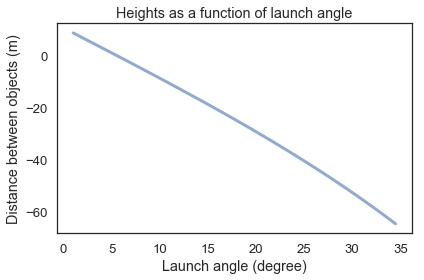

In [13]:
plot(calc_angle_distances(angles, params))
decorate(xlabel='Launch angle (degree)',
         ylabel='Distance between objects (m)',
         title='Heights as a function of launch angle',
         legend=False)

### Calculate Difference in Y-Height

As we can see from the chart and the plot above, the optimal angle to get the y positions of the objects the same is somewhere between 4 and 7 degrees. We created another function to be used in the fsolve function where we put in an expected angle around  6 degrees, that can then be used to check what the actual angle needed is. To set up the fsolve, we had to make this  calc_difference function to run the simulation with our specific optimal angle.

In [14]:
def calc_difference(angle, params): #system, params

    params.angle_b = angle
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func) #ode_solver is like run_simulation
    end_y_pigeon = get_last_value(results.yp) * m
    end_y_bullet= get_last_value(results.yb) * m
    difference = end_y_pigeon - end_y_bullet #calculating distances ebtween y positions.
        
    return difference

# Results

### Fsolve

We used the fsolve command to find the exact angle when the difference in the y-positions of the bullet and pigeon is 0. We used an initial guess of 6 degrees and then printed the actual angle which fsolve found to be 5.58 degrees.

In [15]:
optimal = fsolve(calc_difference, 6, params)[0] #6 is the initial guess for the optimal angle
print(optimal)

5.577191551063826


### Plotting Trajectories

After finding the optimal angle for collision, we made a copy of the initial parameters and replaced the initial angle that the bullet is shot at with the optimal angle, in this case 5.58 degrees. With this new data, we could plot the trajectories of the both the pigeon and the bullet and visualize their collision path. We also used get_last_value to find the height/y-position at which the pigeon and bullet collide.

In [16]:
params_opt = copy(params) #copies object without changing it so we can use params elsewhere
params_opt.angle_b = optimal * degree #replacing the angle with the optimal angle
system_opt = make_system(params_opt)
results, details = run_ode_solver(system_opt, slope_func, events=event_func, max_step = 0.1) #ode_solver is like run_simulation
#print(results)

## Plot 2

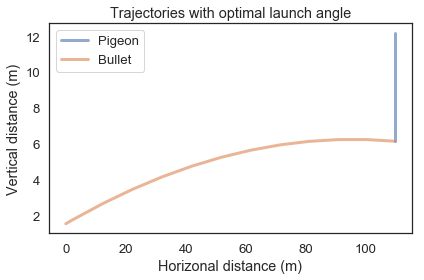

In [17]:
plot(results.xp, results.yp, label = 'Pigeon')
plot(results.xb, results.yb, label = 'Bullet')
decorate(xlabel='Horizonal distance (m)',
         ylabel='Vertical distance (m)',
         title='Trajectories with optimal launch angle',
         legend = True)

In [18]:
#finding the vertical height at which the pigeon and the bullet collide
vert_dist = get_last_value(results.yb)
print (vert_dist)

6.136990657150233


This model used a SweepSeries to determine the optimal angle to fire a shotgun to hit a clay pigeon that is falling from a football field goal post from the other side of the field.

We answered our design question (what is the optimal angle from the ground that a shooter should fire a bullet at a falling clay pigeon while playing the new game of pigeon ball?) by finding that the optimal angle is 5.58 degrees. While this angle seems small and low to the ground, it makes sense due to the very high speed at which the bullet is traveling across the field after being shot.

In our first figure, we show how the difference in y-position  between the pigeon and the bullet change as a function of the launch angle. The line crosses 0 on the y-axis between 0 and 10 degrees, indicating our optimal angle would be somewhere in between. The second figure depicts the trajectory of the pigeon and the bullet when the optimal angle is placed into params. We can see that the two object collide 6.137 meters above the ground.

# Interpretation

Iteration played an important role in our model. We originally made a model that involved a stationary apple in a tree while the gun fired so that we could start simple and only model the forces on the bullet’s travel before introducing a second moving object. Making a basic working model and then introducing new factors to answer our question was a very successful strategy and prevented us from being daunted by the task of modeling the independent movement of two objects until they collided. 
We also learned the value of testing each function as we created it when we got complicated errors and needed to retrace our steps and see what function wasn’t working correctly. 

Our model and question involving pigeon ball are valuable because skeet shooter and hunters will know at what angle to aim to accurately hit a free-falling pigeon or other target object. 

Our model worked quite well, but it could have been made even better by incorporating terminal velocity. Including the universal gravitational attraction between the bullet and pigeon would likely have no effect on the system since these forces are so small but are real-world forces. Including these force if we had more time to improve our program might have made our model more accurately reflect the physical world although not significantly change our results.


## Sources
https://www.infoplease.com/science-health/measurements/standard-measurements-sports

https://www.quora.com/What-would-it-feel-like-to-get-shot-with-a-2-mm-Kolibri

https://www.pewpewtactical.com/demystifying-shotgun-shell-terms/

https://en.wikipedia.org/wiki/Clay_pigeon_shooting
